In [1]:
import pandas as pd
import numpy as np
import wrds
import datetime as dt
import matplotlib.pyplot as plt
import pickle 

## Step 1: Get the CRSP Quarterly Data

In [67]:
with open('price.pkl', 'wb') as f:
    pickle.dump(price, f)

In [66]:
# set sample date range
begdate = '01/01/1990'
enddate = '08/31/2024'

# data extraction
price = conn.raw_sql(f"""
                        SELECT permno, date, cfacpr, cfacshr, shrout, prc, ret
                        FROM crspq.msf
                        WHERE date BETWEEN '{begdate}' AND '{enddate}'
                        """, date_cols = ['date'])

In [2]:
with open('price_v2.pkl', 'rb') as f:
    price = pickle.load(f)

In [9]:
price.tail()

,permno,date,cfacpr,cfacshr,shrout,prc,ret
204810,93426,2024-06-28,1.0,1.0,12331.0,30.44000,-0.098608
204811,93427,2024-06-28,1.0,1.0,36145.0,244.78999,0.021960
204812,93429,2024-06-28,1.0,1.0,105154.0,170.06000,-0.016937
204813,93434,2024-06-28,1.0,1.0,43344.0,0.36000,0.139241
204814,93436,2024-06-28,1.0,1.0,3189196.0,197.88000,0.111186


In [10]:
# get month and quarter-end dates
price['mdate'] = price['date'] + pd.offsets.MonthEnd(0)
price['qdate'] = price['date'] + pd.offsets.QuarterEnd(0)

# calculate adjusted price, total shares and market cap
price['p'] = price['prc'].abs()/price['cfacpr'] 
price['tso'] = price['shrout']*price['cfacshr']*1e3

# keep only the records with shrout > 0
price = price[price['shrout'] > 0]
price = price[['permno','mdate','qdate','date','cfacshr', 'p', 'tso','ret']]
price.head()

,permno,mdate,qdate,date,cfacshr,p,tso,ret
0,10001,1990-01-31,1990-03-31,1990-01-31,3.0,3.312500,3066000.0,-0.018519
1,10002,1990-01-31,1990-03-31,1990-01-31,1.5,4.166667,1762500.0,0.020408
2,10003,1990-01-31,1990-03-31,1990-01-31,1.0,7.750000,2194000.0,-0.088235
3,10005,1990-01-31,1990-03-31,1990-01-31,1.0,0.062500,8376000.0,0.000000
4,10007,1990-01-31,1990-03-31,1990-01-31,1.0,3.593750,4120000.0,-0.474886


In [11]:
# create log return for computing quarterly compound return
price['ret'] = price['ret'].fillna(0)
price['logret'] = np.log(1 + price['ret'])

qret = price.groupby(['permno', 'qdate'])['logret'].sum().reset_index()
qret['qret'] = np.exp(qret['logret']) - 1
qret.head()

,permno,qdate,logret,qret
0,10001,1990-03-31,-0.012423,-0.012346
1,10001,1990-06-30,0.001266,0.001266
2,10001,1990-09-30,0.014005,0.014103
3,10001,1990-12-31,-0.011606,-0.011539
4,10001,1991-03-31,0.014369,0.014473


In [12]:
# shift qdate by one quarter to make qret next quarter return
qret['qdate'] = qret['qdate'] + pd.offsets.QuarterEnd(-1)
qret = qret.drop(columns = ['logret'], axis = 1)

In [13]:
# Keep Quarterly Observations and Add Forward Quarterly Returns
price = price[price['qdate'] == price['mdate']]
price = price[['qdate', 'permno', 'cfacshr', 'p', 'tso']]
price = pd.merge(price, qret, how = 'left', on = ['permno', 'qdate'])
price.head()

,qdate,permno,cfacshr,p,tso,qret
0,1990-03-31,10001,3.0,3.291667,3081000.0,0.001266
1,1990-03-31,10002,1.5,4.250000,1762500.0,0.000000
2,1990-03-31,10003,1.0,8.000000,2194000.0,-0.281250
3,1990-03-31,10005,1.0,0.046880,8376000.0,0.000000
4,1990-03-31,10007,1.0,2.218750,4134000.0,-0.112677


In [14]:
with open('price_v2.pkl', 'wb') as f:
    pickle.dump(price, f)

## Step 2: Merge TR13F S34Type1 & Type3 datasets

In [ ]:
fst_vint = conn.raw_sql("""
                        SELECT rdate, fdate, mgrno, mgrname
                        FROM tfn.s34type1
""", date_cols = ['rdate', 'fdate'])

In [31]:
with open('fst_vint.pkl', 'wb') as f:
    pickle.dump(fst_vint, f)

In [25]:
with open('fst_vint.pkl', 'rb') as f:
    fst_vint = pickle.load(f)

In [27]:
# keep first vintage with holdings data for each rdate_mgrno combination: to solve the issue with multiple FDATEs for the same RDATE.
min_fdate = fst_vint.groupby(['mgrno', 'rdate'])['fdate'].min().reset_index()

# merge back with the fst_vint adta to keep on the first vintage records
fst_vint = pd.merge(fst_vint, min_fdate, how = 'inner', on = ['mgrno', 'rdate', 'fdate'])

# sort by mgrno and rdate and create lag_rdate to calculate gap
fst_vint = fst_vint.sort_values(by = ['mgrno', 'rdate'])
fst_vint['lag_rdate'] = fst_vint.groupby(['mgrno'])['rdate'].shift(1)
fst_vint.head()

,rdate,fdate,mgrno,mgrname,lag_rdate
68889,1998-12-31,1998-12-31,110.0,A R ASSET MANAGEMENT INC,NaT
70539,1999-03-31,1999-03-31,110.0,A R ASSET MANAGEMENT INC,1998-12-31
72009,1999-06-30,1999-06-30,110.0,"A R ASSET MANAGEMENT, INC.",1999-03-31
73518,1999-09-30,1999-09-30,110.0,"A R ASSET MANAGEMENT, INC.",1999-06-30
75115,1999-12-31,1999-12-31,110.0,"A R ASSET MANAGEMENT, INC.",1999-09-30


In [30]:
# number of quarters gap between rdate and lag_rdate
fst_vint['qtr'] = (fst_vint['rdate'].dt.to_period('Q') - fst_vint['lag_rdate'].dt.to_period('Q')).apply(lambda x: x.n if pd.notnull(x) else pd.NA)

# label first_report flag
fst_vint['first_report'] = (fst_vint.qtr.isnull()) | (fst_vint.qtr >= 2)
fst_vint = fst_vint.drop(['qtr'], axis = 1)

# last report by manager or missing 13F reports in the next quarters
fst_vint = fst_vint.sort_values(['mgrno', 'rdate'], ascending = [True, False])
fst_vint['lead_rdate'] = fst_vint.groupby(['mgrno'])['rdate'].shift(1)

# Number of quarters gap between lead_rdate and rdate
fst_vint['qtr'] = (fst_vint['lead_rdate'].dt.to_period('Q') - fst_vint['rdate'].dt.to_period('Q')).apply(lambda x: x.n if pd.notnull(x) else pd.NA)

# # label last_report flag
fst_vint['last_report'] = (fst_vint.qtr.isnull()) | (fst_vint.qtr >= 2)
fst_vint = fst_vint.drop(['qtr'], axis = 1)

fst_vint = fst_vint[(fst_vint['rdate'] <= enddate) & (fst_vint['rdate'] >= begdate)].drop(['lag_rdate', 'lead_rdate'], axis = 1)
fst_vint.head()

,rdate,fdate,mgrno,mgrname,first_report,last_report
421870,2023-12-31,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True
414869,2023-09-30,2023-09-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False
407973,2023-06-30,2023-06-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False
401143,2023-03-31,2023-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False
394151,2022-12-31,2022-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False


## Step 3: Extract Holidngs and Adjusted Shares

In [3]:
# Fdate - Vintage Date - is used in shares adjustment
s34type3 = conn.raw_sql("""
                      select fdate, mgrno, cusip, shares
                      from tfn.s34type3
                      where fdate between '2010-01-01' and '2024-08-31'
                      """, date_cols=['fdate']) 

In [4]:
with open('s34type3.pkl', 'wb') as f:
    pickle.dump(s34type3, f)

In [21]:
with open('s34type3.pkl', 'rb') as f:
    s34type3 = pickle.load(f)

In [22]:
s34type3.head()

,fdate,mgrno,cusip,shares
0,2010-03-31,110.0,00206R10,59723.0
1,2010-03-31,110.0,01717510,1533.0
2,2010-03-31,110.0,01881G10,10000.0
3,2010-03-31,110.0,02209S10,100306.0
4,2010-03-31,110.0,02553710,10000.0


In [23]:
holdings_v1 = pd.merge(fst_vint, s34type3, how = 'inner', on = ['fdate', 'mgrno'])
holdings_v1.head()

,rdate,fdate,mgrno,mgrname,first_report,last_report,cusip,shares
0,2023-12-31,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True,00282410,8700.0
1,2023-12-31,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True,00287Y10,43200.0
2,2023-12-31,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True,0076CA10,36691.0
3,2023-12-31,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True,00846U10,1593.0
4,2023-12-31,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True,02000210,2000.0


In [36]:
# Map 13F's historical cusip to CRSP's permno information

crsp = conn.raw_sql("""
                    select distinct permno, ncusip, ticker
                    from crsp.msenames
                    where ncusip != ''
""")

In [41]:
with open('crsp.pkl', 'wb') as f:
    pickle.dump(crsp, f)

In [50]:
with open('crsp.pkl', 'rb') as f:
    crsp = pickle.load(f)

In [25]:
holdings_v2 = pd.merge(holdings_v1, crsp, how = 'inner', left_on = 'cusip', right_on = 'ncusip')
holdings_v2 = holdings_v2.drop(['cusip', 'ncusip'], axis = 1)
holdings_v2.head()

,rdate,fdate,mgrno,mgrname,first_report,last_report,shares,permno,ticker
0,2023-12-31,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True,8700.0,20482,ABT
1,2023-12-31,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True,43200.0,13721,ABBV
2,2023-12-31,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True,36691.0,85172,AEG
3,2023-12-31,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True,1593.0,87432,A
4,2023-12-31,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True,2000.0,79323,ALL


In [26]:
with open('holdings_v2.pkl', 'wb') as f:
    pickle.dump(holdings_v2, f)

In [4]:
with open('holdings_v2.pkl', 'rb') as f:
    holdings_v2 = pickle.load(f)

## Step 4: Adjust Shares using CRSP CFACSHR, Align at Vintage Dates

In [9]:
holdings = pd.merge(holdings_v2, price[['qdate', 'permno', 'cfacshr']], how = 'inner', left_on = ['permno', 'fdate'], right_on = ['permno', 'qdate'])
holdings.head()

,rdate,fdate,mgrno,mgrname,first_report,last_report,shares,permno,ticker,qdate,cfacshr
0,2023-12-31,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True,8700.0,20482,ABT,2023-12-31,1.0
1,2023-12-31,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True,43200.0,13721,ABBV,2023-12-31,1.0
2,2023-12-31,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True,36691.0,85172,AEG,2023-12-31,1.0
3,2023-12-31,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True,1593.0,87432,A,2023-12-31,1.0
4,2023-12-31,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True,2000.0,79323,ALL,2023-12-31,1.0


In [28]:
holdings.shape

(72926510, 11)

In [10]:
# calculate adjusted shares
holdings['shares_adj'] = holdings['shares']*holdings['cfacshr']
holdings = holdings.drop(['qdate', 'cfacshr', 'fdate'], axis = 1)

# check for duplicates
holdings = holdings.drop_duplicates(subset=['mgrno','permno','rdate'])

# Keep only observations with shares_adj>0
holdings = holdings[holdings['shares_adj']>0]

holdings.head()

,rdate,mgrno,mgrname,first_report,last_report,shares,permno,ticker,shares_adj
0,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True,8700.0,20482,ABT,8700.0
1,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True,43200.0,13721,ABBV,43200.0
2,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True,36691.0,85172,AEG,36691.0
3,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True,1593.0,87432,A,1593.0
4,2023-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,True,2000.0,79323,ALL,2000.0


In [11]:
with open('holdings.pkl', 'wb') as f:
    pickle.dump(holdings, f)

In [3]:
with open('holdings.pkl', 'rb') as f:
    holdings = pickle.load(f)

## Step 5: Calculate Institutional Trades
- Calculate Institutional Trades
- Security-by-Security
- trade>0 -> Buy vs trade<0 -> Sale
- buysale variable for trade types: 
(1 = Initiating Buys,  2 = Incremental (Regular) Buys,   -1 = Terminating Sales,   -2 = Regular Sales)

In [7]:
t1.head()

,rdate,mgrno,mgrname,first_report,last_report,shares,permno,ticker,shares_adj
1436,2021-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000.0,10104,ORCL,3000.0
1307,2021-06-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000.0,10104,ORCL,3000.0
1179,2021-09-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000.0,10104,ORCL,3000.0
1053,2021-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000.0,10104,ORCL,3000.0
926,2022-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000.0,10104,ORCL,3000.0


In [19]:
t1 = holdings.sort_values(['mgrno', 'permno', 'rdate'])
t1.head()

# reduce the size of the dataframe:
t1['mgrno'] = t1['mgrno'].astype(np.float32)
t1['shares'] = t1['shares'].astype(np.int32)
t1['shares_adj'] = t1['shares_adj'].astype(np.int32)
t1['permno'] = t1['permno'].astype(np.int32)
t1['mgrname'] = t1['mgrname'].astype('category')
t1['ticker'] = t1['ticker'].astype('category')

# previous holdings quarter
t1['phrdate'] = t1.groupby(['mgrno', 'permno'])['rdate'].shift(1)
t1.head()
# previous quarter shares
t1['pshares_adj'] = t1.groupby(['mgrno','permno'])['shares_adj'].shift(1)
t1.head()
# trade as difference in current and previous quarter shares
t1['trade'] = t1['shares_adj'] - t1['pshares_adj']
t1.head()

# quarter gap
t1['qtrgap'] = (t1['rdate'].dt.to_period('Q')-t1['phrdate'].dt.to_period('Q')).apply(lambda x: x.n if pd.notnull(x) else pd.NA)
t1.head()

,rdate,mgrno,mgrname,first_report,last_report,shares,permno,ticker,shares_adj,phrdate,pshares_adj,trade,qtrgap
1436,2021-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,NaT,NaN,NaN,<NA>
1307,2021-06-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,2021-03-31,3000.0,0.0,1
1179,2021-09-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,2021-06-30,3000.0,0.0,1
1053,2021-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,2021-09-30,3000.0,0.0,1
926,2022-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,2021-12-31,3000.0,0.0,1


In [8]:
# lag permno for dtermining first permno
t1['lpermno'] = t1['permno'].shift(1)

# lead permno for determining last permno
t1['npermno'] = t1['permno'].shift(-1)
t1.head()

,rdate,mgrno,mgrname,first_report,last_report,shares,permno,ticker,shares_adj,phrdate,pshares_adj,trade,qtrgap,lpermno,npermno
1436,2021-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,NaT,NaN,NaN,NaN,NaN,10104.0
1307,2021-06-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,2021-03-31,3000.0,0.0,1,10104.0,10104.0
1179,2021-09-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,2021-06-30,3000.0,0.0,1,10104.0,10104.0
1053,2021-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,2021-09-30,3000.0,0.0,1,10104.0,10104.0
926,2022-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,2021-12-31,3000.0,0.0,1,10104.0,10104.0


In [10]:
# further reduce the table size
t1['qtrgap'] = t1['qtrgap'].astype('category')
t1['trade'] = t1['trade'].astype(np.float32)
t1['pshares_adj'] = t1['pshares_adj'].astype(np.float32)
t1['lpermno'] = t1['lpermno'].astype(np.float32)
t1['npermno'] = t1['npermno'].astype(np.float32)
t1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62992035 entries, 1436 to 72925331
Data columns (total 15 columns):
 #   Column        Dtype         
---  ------        -----         
 0   rdate         datetime64[ns]
 1   mgrno         float32       
 2   mgrname       category      
 3   first_report  bool          
 4   last_report   bool          
 5   shares        int32         
 6   permno        int32         
 7   ticker        category      
 8   shares_adj    int32         
 9   phrdate       datetime64[ns]
 10  pshares_adj   float32       
 11  trade         float32       
 12  qtrgap        category      
 13  lpermno       float32       
 14  npermno       float32       
dtypes: bool(2), category(3), datetime64[ns](2), float32(5), int32(3)
memory usage: 3.7 GB


In [11]:
with open('t1.pkl', 'wb') as f:
    pickle.dump(t1, f)

In [5]:
with open('t1.pkl', 'rb') as f:
    t1 = pickle.load(f)

In [13]:
t1.head()

,rdate,mgrno,mgrname,first_report,last_report,shares,permno,ticker,shares_adj,phrdate,pshares_adj,trade,qtrgap,lpermno,npermno
1436,2021-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,NaT,NaN,NaN,NaN,NaN,10104.0
1307,2021-06-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,2021-03-31,3000.0,0.0,1,10104.0,10104.0
1179,2021-09-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,2021-06-30,3000.0,0.0,1,10104.0,10104.0
1053,2021-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,2021-09-30,3000.0,0.0,1,10104.0,10104.0
926,2022-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,2021-12-31,3000.0,0.0,1,10104.0,10104.0


In [12]:
# list condition: 
cond1 = t1.permno != t1.lpermno  # new buy
cond1_1 = (t1.permno != t1.lpermno) & (~t1.first_report) # initial mask
cond2_1 = (t1.permno == t1.lpermno) & (~t1.first_report) & (t1.qtrgap == 1) # sequential mask
cond2_2 = (t1.permno == t1.lpermno) & (~t1.first_report) & (t1.qtrgap != 1)

In [16]:
# Assgin modtrade value based on the conditions listed above: 
t1['modtrade'] = t1['trade']
t1.loc[cond1, 'modtrade'] = np.nan
t1.loc[cond1_1, 'modtrade'] = t1.loc[cond1_1, 'shares_adj']
t1.loc[cond2_1, 'modtrade'] = t1.loc[cond2_1, 'trade']
t1.loc[cond2_2, 'modtrade'] = t1.loc[cond2_2, 'shares_adj']
t1.head()

C:\Users\m1852\AppData\Local\Temp\ipykernel_18324\330798261.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  3000  12000  10172 ... 160000 244000  18200]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  t1.loc[cond1_1, 'modtrade'] = t1.loc[cond1_1, 'shares_adj']


,rdate,mgrno,mgrname,first_report,last_report,shares,permno,ticker,shares_adj,phrdate,pshares_adj,trade,qtrgap,lpermno,npermno,modtrade
1436,2021-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,NaT,NaN,NaN,NaN,NaN,10104.0,3000.0
1307,2021-06-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,2021-03-31,3000.0,0.0,1,10104.0,10104.0,0.0
1179,2021-09-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,2021-06-30,3000.0,0.0,1,10104.0,10104.0,0.0
1053,2021-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,2021-09-30,3000.0,0.0,1,10104.0,10104.0,0.0
926,2022-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,2021-12-31,3000.0,0.0,1,10104.0,10104.0,0.0


In [17]:
# Assign buysale value based on the conditions
t1.loc[cond1_1, 'buysale'] = 1
t1.loc[cond2_1, 'buysale'] = 2*np.sign(t1.loc[cond2_1, 'trade'])
t1.loc[cond2_2, 'buysale'] = 1.5
t1.head()

,rdate,mgrno,mgrname,first_report,last_report,shares,permno,ticker,shares_adj,phrdate,pshares_adj,trade,qtrgap,lpermno,npermno,modtrade,buysale
1436,2021-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,NaT,NaN,NaN,NaN,NaN,10104.0,3000.0,1.0
1307,2021-06-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,2021-03-31,3000.0,0.0,1,10104.0,10104.0,0.0,0.0
1179,2021-09-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,2021-06-30,3000.0,0.0,1,10104.0,10104.0,0.0,0.0
1053,2021-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,2021-09-30,3000.0,0.0,1,10104.0,10104.0,0.0,0.0
926,2022-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,3000,10104,ORCL,3000,2021-12-31,3000.0,0.0,1,10104.0,10104.0,0.0,0.0


In [22]:
# adjusting rdate for termniating sales records: 
t1['rdate'] = np.where(t1['buysale'] == -1, t1['rdate'] + pd.offsets.QuarterEnd(1), t1['rdate'])

In [23]:
# Focusing on cases of intermediate sales - with gaps > 1 qtr 
# Then need to split transaction into 2
t2=t1[(t1.buysale==1.5)]
t2['rdate'] = t2['phrdate']+pd.offsets.QuarterEnd(1)

t2['buysale'] = -1
t2['modtrade'] = -t2['pshares_adj']

C:\Users\m1852\AppData\Local\Temp\ipykernel_18324\2184986190.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t2['rdate'] = t2['phrdate']+pd.offsets.QuarterEnd(1)
C:\Users\m1852\AppData\Local\Temp\ipykernel_18324\2184986190.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t2['buysale'] = -1
C:\Users\m1852\AppData\Local\Temp\ipykernel_18324\2184986190.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [24]:
# Go back to modify the t1 dataset with buysale variable labeled as 1.5
t1['buysale'] = np.where(t1['buysale']==1.5, 1, t1['buysale'])

# handle terminating sales
t3 = t1[(t1.permno != t1.npermno) & (t1.last_report == False)]

t3['rdate'] = t3['rdate']+pd.offsets.QuarterEnd(1)
t3['modtrade'] = -t3['shares_adj']
t3['buysale'] = -1

C:\Users\m1852\AppData\Local\Temp\ipykernel_18324\918425338.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t3['rdate'] = t3['rdate']+pd.offsets.QuarterEnd(1)
C:\Users\m1852\AppData\Local\Temp\ipykernel_18324\918425338.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t3['modtrade'] = -t3['shares_adj']
C:\Users\m1852\AppData\Local\Temp\ipykernel_18324\918425338.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [29]:
# Append t1 t2 and t3 to create the complete trades output
trades = pd.concat([t1, t2])
trades = pd.concat([trades, t3])
trades = trades[(trades.modtrade != 0)&(trades.modtrade.notna())&(trades.buysale.notna())]
trades = trades[['rdate','mgrno','permno','modtrade','buysale']]\
.rename(columns={'modtrade':'trade'})

In [34]:
trades.head()

,rdate,mgrno,permno,trade,buysale
1436,2021-03-31,110.0,10104,3000.0,1.0
548,2022-12-31,110.0,10104,3000.0,1.0
6462,2010-03-31,110.0,10107,12000.0,1.0
6131,2010-12-31,110.0,10107,-200.0,-2.0
5929,2011-06-30,110.0,10107,2000.0,2.0


In [33]:
with open('trades.pkl', 'wb') as f: 
    pickle.dump(trades, f)

In [4]:
with open('trades.pkl', 'rb') as f: 
    trades = pickle.load(f)

## Step 6: Calculate Assets, Total Buys and Total Sales per Institution Each Quarter

In [5]:
# Get Total Assets and Portfolio Returns from Holdings  
# Assuming Buys and Sales Are Executed at Calendar Quarter Ends

_holdings = holdings[['mgrno','permno','rdate','shares_adj']]
_price    = price[['permno','qdate','p','qret']]
_assets   = pd.merge(_holdings, _price, \
                  how='inner', left_on=['permno','rdate'], right_on=['permno','qdate'])
_assets.head()

,mgrno,permno,rdate,shares_adj,qdate,p,qret
0,110.0,20482,2023-12-31,8700.0,2023-12-31,110.07,0.037635
1,110.0,13721,2023-12-31,43200.0,2023-12-31,154.97,0.186144
2,110.0,85172,2023-12-31,36691.0,2023-12-31,5.76,0.050347
3,110.0,87432,2023-12-31,1593.0,2023-12-31,139.03,0.046608
4,110.0,79323,2023-12-31,2000.0,2023-12-31,139.98,0.242534


In [9]:
# create intermediate variables before summing by manager and quarter

# dollar held in each stock per quarter per manager
_assets['hold_per_stock'] = _assets['shares_adj']*_assets['p']/1000000
# dollar held projected to next quarter assuming same shares held
_assets['next_value'] = _assets['shares_adj']*_assets['p']*_assets['qret']
# dollar held curent quarter
_assets['curr_value'] = _assets['shares_adj']*_assets['p']

_assets = _assets.sort_values(['mgrno','rdate'])

_assets.head()

,mgrno,permno,rdate,shares_adj,qdate,p,qret,hold_per_stock,next_value,curr_value
5403,110.0,66093,2010-03-31,59723.00,2010-03-31,19.794926,-0.048768,1.182212,-57653.623784,1.182212e+06
5404,110.0,71271,2010-03-31,1563.66,2010-03-31,285.098029,0.008597,0.445796,3832.487338,4.457964e+05
5405,110.0,75278,2010-03-31,10000.00,2010-03-31,30.660000,-0.143552,0.306600,-44013.093677,3.066000e+05
5406,110.0,13901,2010-03-31,100306.00,2010-03-31,20.520000,-0.006335,2.058279,-13039.268266,2.058279e+06
5407,110.0,24109,2010-03-31,10000.00,2010-03-31,34.180000,-0.042585,0.341800,-14555.470728,3.418000e+05


In [10]:
# sum values across different stocks by a manager in a quarter
hold_per_stock = _assets.groupby(['mgrno','rdate'])['hold_per_stock'].sum().reset_index()
next_qtr = _assets.groupby(['mgrno','rdate'])['next_value'].sum().reset_index()
curr_qtr = _assets.groupby(['mgrno','rdate'])['curr_value'].sum().reset_index()

In [29]:
# Forward portfolio return
pret = pd.merge(next_qtr, curr_qtr, how='inner', on=['mgrno','rdate'])
pret['pret'] = pret['next_value']/pret['curr_value']
pret = pret[['mgrno','rdate','pret']]

assets = pd.merge(hold_per_stock, pret, how='inner',on=['mgrno','rdate'])

# Total portfolio Assets
assets = assets.rename(columns={'hold_per_stock':'assets'})
assets.head()

,mgrno,rdate,assets,pret
0,110.0,2010-03-31,141.238199,-0.103212
1,110.0,2010-06-30,118.931465,0.129421
2,110.0,2010-09-30,133.712105,0.087421
3,110.0,2010-12-31,142.964859,0.073328
4,110.0,2011-03-31,147.720849,0.012680


In [15]:
# reduce the size
trades['buysale'] = trades['buysale'].astype(np.float32)
trades['trade'] = trades['trade'].astype(np.float32)

In [16]:
trades.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58592610 entries, 1436 to 72925331
Data columns (total 5 columns):
 #   Column   Dtype         
---  ------   -----         
 0   rdate    datetime64[ns]
 1   mgrno    float32       
 2   permno   int32         
 3   trade    float32       
 4   buysale  float32       
dtypes: datetime64[ns](1), float32(3), int32(1)
memory usage: 1.7 GB


In [17]:
# Aggregate Total Buys and Sales per Institution Every Quarter 

# create intermediate variables first
_flows = pd.merge(trades, _price, how='inner', \
                  left_on=['permno','rdate'], right_on=['permno','qdate'])

_flows.head()

,rdate,mgrno,permno,trade,buysale,qdate,p,qret
0,2021-03-31,110.0,10104,3000.0,1.0,2021-03-31,70.1700,0.113990
1,2022-12-31,110.0,10104,3000.0,1.0,2022-12-31,81.7400,0.140888
2,2010-03-31,110.0,10107,12000.0,1.0,2010-03-31,29.2875,-0.210383
3,2010-12-31,110.0,10107,-200.0,-2.0,2010-12-31,27.9100,-0.084815
4,2011-06-30,110.0,10107,2000.0,2.0,2011-06-30,26.0000,-0.036935


In [19]:
# dollar amount buys per stock by a manager in a quarter
_flows['tbuys']  = _flows['trade']*(_flows['trade']>0) * _flows['p']/1000000
# dollar amount sells per stock by a manager in a quarter
_flows['tsales'] = (-1)*_flows['trade']*(_flows['trade']<0) * _flows['p']/1000000
# net gain from trades per stock 
_flows['tgain']  = _flows['trade']*_flows['p']*_flows['qret']/1000000

_flows.head()

,rdate,mgrno,permno,trade,buysale,qdate,p,qret,tbuys,tsales,tgain
0,2021-03-31,110.0,10104,3000.0,1.0,2021-03-31,70.1700,0.113990,0.21051,-0.000000,0.023996
1,2022-12-31,110.0,10104,3000.0,1.0,2022-12-31,81.7400,0.140888,0.24522,-0.000000,0.034548
2,2010-03-31,110.0,10107,12000.0,1.0,2010-03-31,29.2875,-0.210383,0.35145,-0.000000,-0.073939
3,2010-12-31,110.0,10107,-200.0,-2.0,2010-12-31,27.9100,-0.084815,-0.00000,0.005582,0.000473
4,2011-06-30,110.0,10107,2000.0,2.0,2011-06-30,26.0000,-0.036935,0.05200,-0.000000,-0.001921


In [23]:
# sum values across different stocks by a manager in a quarter
tbuys  = _flows.groupby(['mgrno','rdate'])['tbuys'].sum().reset_index()
tsales = _flows.groupby(['mgrno','rdate'])['tsales'].sum().reset_index()
tgain  = _flows.groupby(['mgrno','rdate'])['tgain'].sum().reset_index()

ttran = pd.merge(tbuys, tsales, how='inner', on =['mgrno','rdate'])

# Flows dataframe
flows = pd.merge(ttran, tgain, how='inner',on=['mgrno','rdate'])
flows.head()

,mgrno,rdate,tbuys,tsales,tgain
0,110.0,2010-03-31,141.237876,0.000000,-14.577427
1,110.0,2010-06-30,1.606081,8.247372,-0.333303
2,110.0,2010-09-30,1.855033,1.344226,-0.191478
3,110.0,2010-12-31,0.684224,1.605898,-0.017001
4,110.0,2011-03-31,0.842992,5.396383,-0.324971


## Step 7: Calculate net Flows and Turnover

In [26]:
fst_vint = fst_vint.sort_values(['mgrno','rdate'])
fst_vint = fst_vint.drop_duplicates(subset=['mgrno','rdate'])

In [30]:
# inner join fst_vint and assets dataframes then left join with flows
_agg1 = pd.merge(fst_vint, assets, how='inner', on =['mgrno','rdate'])
_agg1 = _agg1.drop(['fdate'], axis=1)
aggregates = pd.merge(_agg1, flows, how='left', on=['mgrno','rdate'])
aggregates.head()

,rdate,mgrno,mgrname,first_report,last_report,assets,pret,tbuys,tsales,tgain
0,2010-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,141.238199,-0.103212,141.237876,0.000000,-14.577427
1,2010-06-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,118.931465,0.129421,1.606081,8.247372,-0.333303
2,2010-09-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,133.712105,0.087421,1.855033,1.344226,-0.191478
3,2010-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,142.964859,0.073328,0.684224,1.605898,-0.017001
4,2011-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,147.720849,0.012680,0.842992,5.396383,-0.324971


In [31]:
# assets compound value
aggregates['assets_comp'] = aggregates['assets']*(1+aggregates['pret'])
aggregates = aggregates.sort_values(['mgrno','rdate'])
# lag asset compound value
aggregates['lassets_comp'] = aggregates.groupby(['mgrno'])['assets_comp'].shift(1)
# lag asset value
aggregates['lassets'] = aggregates.groupby(['mgrno'])['assets'].shift(1)

In [32]:
# Trade Returns = Returns on Purchases - Forgone Returns on Sales
aggregates['tgainret'] = aggregates['tgain']/(aggregates['tbuys'] + aggregates['tsales'])
aggregates['netflows'] = aggregates['assets'] - aggregates['lassets_comp']

aggregates.head()

,rdate,mgrno,mgrname,first_report,last_report,assets,pret,tbuys,tsales,tgain,assets_comp,lassets_comp,lassets,tgainret,netflows
0,2010-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,141.238199,-0.103212,141.237876,0.000000,-14.577427,126.660752,NaN,NaN,-0.103212,NaN
1,2010-06-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,118.931465,0.129421,1.606081,8.247372,-0.333303,134.323688,126.660752,141.238199,-0.033826,-7.729286
2,2010-09-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,133.712105,0.087421,1.855033,1.344226,-0.191478,145.401384,134.323688,118.931465,-0.059851,-0.611583
3,2010-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,142.964859,0.073328,0.684224,1.605898,-0.017001,153.448211,145.401384,133.712105,-0.007423,-2.436526
4,2011-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,147.720849,0.012680,0.842992,5.396383,-0.324971,149.593886,153.448211,142.964859,-0.052084,-5.727361


In [35]:
# Three Types of Turnover Measures

# Carhart (1997) Turnover Definition
aggregates['turnover1'] = \
(aggregates[['tbuys', 'tsales']].min(axis=1)) / (aggregates[['assets', 'lassets']].mean(axis=1))

# Adding Back Net Flows and Redemptions
aggregates['turnover2'] = \
(aggregates[['tbuys', 'tsales']].min(axis=1) + aggregates['netflows'].abs().fillna(0)) \
/ aggregates['lassets']

# or, Alternatively
aggregates['turnover3'] = \
(aggregates['tbuys'].fillna(0)+aggregates['tsales'].fillna(0)\
-aggregates['netflows'].abs().fillna(0))\
/ aggregates['lassets']

aggregates.head()

,rdate,mgrno,mgrname,first_report,last_report,assets,pret,tbuys,tsales,tgain,assets_comp,lassets_comp,lassets,tgainret,netflows,turnover1,turnover2,turnover3
0,2010-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,141.238199,-0.103212,141.237876,0.000000,-14.577427,126.660752,NaN,NaN,-0.103212,NaN,0.000000,NaN,NaN
1,2010-06-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,118.931465,0.129421,1.606081,8.247372,-0.333303,134.323688,126.660752,141.238199,-0.033826,-7.729286,0.012346,0.066097,0.015040
2,2010-09-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,133.712105,0.087421,1.855033,1.344226,-0.191478,145.401384,134.323688,118.931465,-0.059851,-0.611583,0.010641,0.016445,0.021758
3,2010-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,142.964859,0.073328,0.684224,1.605898,-0.017001,153.448211,145.401384,133.712105,-0.007423,-2.436526,0.004946,0.023339,-0.001095
4,2011-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,147.720849,0.012680,0.842992,5.396383,-0.324971,149.593886,153.448211,142.964859,-0.052084,-5.727361,0.005800,0.045958,0.003581


In [36]:
# Assign missing values for first_report records
aggregates['netflows']=np.where(aggregates['first_report'], np.nan, aggregates['netflows'])
aggregates['tgainret']=np.where(aggregates['first_report'], np.nan, aggregates['tgainret'])
aggregates['turnover1']=np.where(aggregates['first_report'], np.nan, aggregates['turnover1'])
aggregates['turnover2']=np.where(aggregates['first_report'], np.nan, aggregates['turnover2'])
aggregates['turnover3']=np.where(aggregates['first_report'], np.nan, aggregates['turnover3'])

aggregates=aggregates.drop(['assets_comp', 'lassets_comp', 'lassets'], axis=1)
aggregates.head()

,rdate,mgrno,mgrname,first_report,last_report,assets,pret,tbuys,tsales,tgain,tgainret,netflows,turnover1,turnover2,turnover3
0,2010-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,141.238199,-0.103212,141.237876,0.000000,-14.577427,-0.103212,NaN,0.000000,NaN,NaN
1,2010-06-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,118.931465,0.129421,1.606081,8.247372,-0.333303,-0.033826,-7.729286,0.012346,0.066097,0.015040
2,2010-09-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,133.712105,0.087421,1.855033,1.344226,-0.191478,-0.059851,-0.611583,0.010641,0.016445,0.021758
3,2010-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,142.964859,0.073328,0.684224,1.605898,-0.017001,-0.007423,-2.436526,0.004946,0.023339,-0.001095
4,2011-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,147.720849,0.012680,0.842992,5.396383,-0.324971,-0.052084,-5.727361,0.005800,0.045958,0.003581


In [40]:
with open("aggregates.pkl", 'wb') as f: 
    pickle.dump(aggregates, f)

In [41]:
with open("aggregates.pkl", 'rb') as f: 
    aggregates = pickle.load(f)

In [94]:
aggregates.head()

,rdate,mgrno,mgrname,first_report,last_report,assets,pret,tbuys,tsales,tgain,tgainret,netflows,turnover1,turnover2,turnover3
0,2010-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,141.238199,-0.103212,141.237876,0.000000,-14.577427,-0.103212,NaN,0.000000,NaN,NaN
1,2010-06-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,118.931465,0.129421,1.606081,8.247372,-0.333303,-0.033826,-7.729286,0.012346,0.066097,0.015040
2,2010-09-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,133.712105,0.087421,1.855033,1.344226,-0.191478,-0.059851,-0.611583,0.010641,0.016445,0.021758
3,2010-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,142.964859,0.073328,0.684224,1.605898,-0.017001,-0.007423,-2.436526,0.004946,0.023339,-0.001095
4,2011-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,147.720849,0.012680,0.842992,5.396383,-0.324971,-0.052084,-5.727361,0.005800,0.045958,0.003581


## Step 8: Analysis and Visualization

### 8.1 Net Inflows analysis

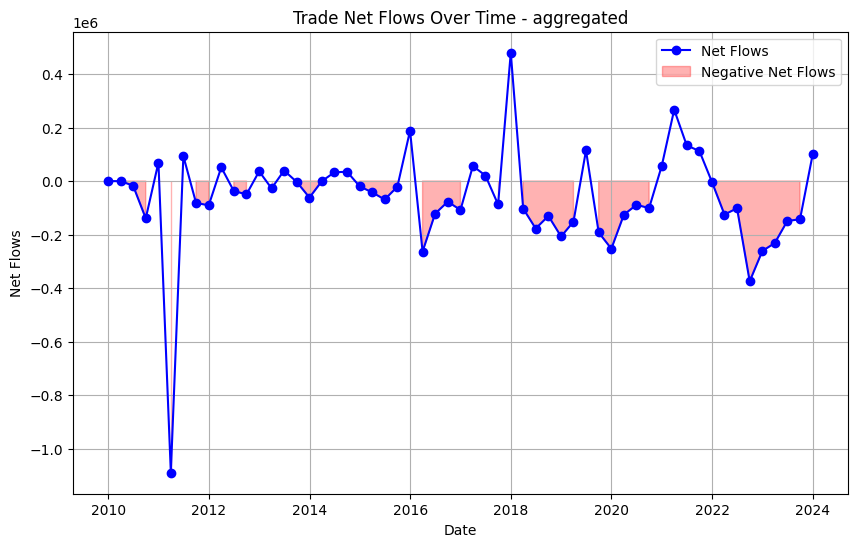

In [97]:
netflows_hist = aggregates.groupby(['rdate'])['netflows'].sum().reset_index()
# Create the plot

def plot_netflows(netflows_hist, name):
    plt.figure(figsize=(10, 6))
    
    # Plot the line chart for net flows
    plt.plot(netflows_hist['rdate'], netflows_hist['netflows'], marker='o', linestyle='-', color='b', label='Net Flows')
    
    # Fill the areas where netflows are below zero
    plt.fill_between(netflows_hist['rdate'], netflows_hist['netflows'], where=(netflows_hist['netflows'] < 0),
                     color='red', alpha=0.3, label='Negative Net Flows')
    
    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Net Flows')
    plt.title(f'Trade Net Flows Over Time - {name}')
    plt.grid(True)
    plt.legend()
    
    # Display the plot
    plt.show()

plot_netflows(netflows_hist, 'aggregated')

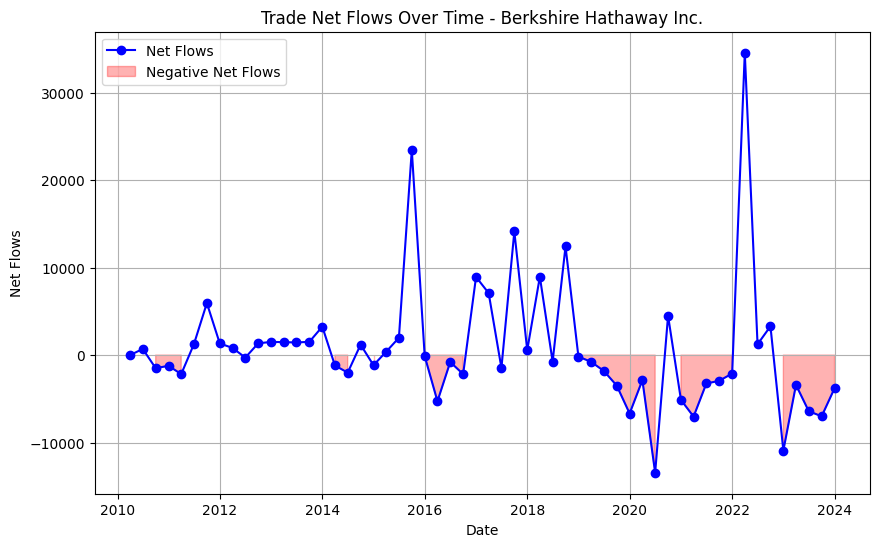

In [98]:
netflows_hist_BH = aggregates.query('mgrname == "BERKSHIRE HATHAWAY INC."').groupby(['rdate'])['netflows'].sum().reset_index()
plot_netflows(netflows_hist_BH, 'Berkshire Hathaway Inc.')

### 8.2 total Gains Analysis

In [99]:
aggregates.head()

,rdate,mgrno,mgrname,first_report,last_report,assets,pret,tbuys,tsales,tgain,tgainret,netflows,turnover1,turnover2,turnover3
0,2010-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,141.238199,-0.103212,141.237876,0.000000,-14.577427,-0.103212,NaN,0.000000,NaN,NaN
1,2010-06-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,118.931465,0.129421,1.606081,8.247372,-0.333303,-0.033826,-7.729286,0.012346,0.066097,0.015040
2,2010-09-30,110.0,"AR ASSET MANAGEMENT, INC.",False,False,133.712105,0.087421,1.855033,1.344226,-0.191478,-0.059851,-0.611583,0.010641,0.016445,0.021758
3,2010-12-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,142.964859,0.073328,0.684224,1.605898,-0.017001,-0.007423,-2.436526,0.004946,0.023339,-0.001095
4,2011-03-31,110.0,"AR ASSET MANAGEMENT, INC.",False,False,147.720849,0.012680,0.842992,5.396383,-0.324971,-0.052084,-5.727361,0.005800,0.045958,0.003581


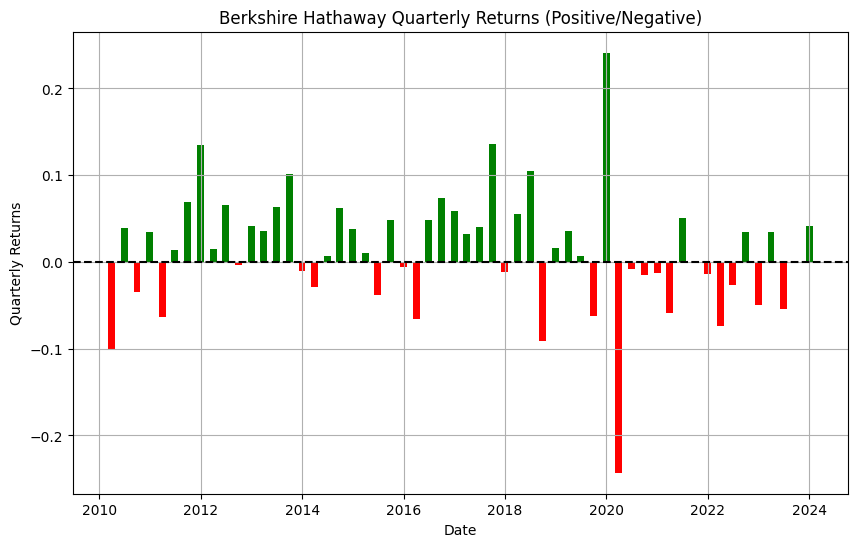

In [104]:
# tgainret_hist_BH = aggregates.query('mgrname == "BERKSHIRE HATHAWAY INC."').groupby(['rdate'])['tgainret'].sum().reset_index()
# Create colors for positive (green) and negative (red) returns
colors = ['green' if x > 0 else 'red' for x in tgainret_hist_BH['tgainret']]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(tgainret_hist_BH['rdate'], tgainret_hist_BH['tgainret'], color=colors, width = 50)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quarterly Returns')
plt.title('Berkshire Hathaway Quarterly Returns (Positive/Negative)')
plt.grid(True)
plt.axhline(0, color='black', linewidth=1.5, linestyle='--')  # Add a horizontal line at 0 for reference

# Display the plot
plt.show()

In [125]:
aggregates['year'] = aggregates.rdate.dt.year
avg_returns = aggregates.groupby(['year', 'mgrname'])['tgainret'].mean().reset_index()
avg_returns.columns = ['Year', 'Manager', 'Average Quarterly Return']
avg_returns

,Year,Manager,Average Quarterly Return
0,2009,"ATLANTIC ADVISORS, LLC",0.026990
1,2009,BLACKROCK INC,0.060550
2,2009,"BOSTON FINL MANAGEMENT, INC.",0.033579
3,2009,CB&T WEALTH MANAGEMENT,NaN
4,2009,DNB NOR ASSET MANAGEMENT AS,NaN
...,...,...,...
72786,2023,ZRC WEALTH MANAGEMENT LLC,0.036079
72787,2023,ZURCHER KANTONALBANK(ASSET MGM,0.021546
72788,2023,ZURICH INSURANCE GROUP,0.003421
72789,2023,"ZWEIG-DIMENNA ASSOCIATES, INC.",0.026237
